In [33]:
# Thực hiện kết nối đến database nếu không tồn tại database, tạo ra database mới
import  sqlite3
con = sqlite3.connect("nam.db")
cur = con.cursor()

In [34]:
# Đọc dữ liệu từ file csv và chuyển dữ liệu vào database
import pandas as pd
df = pd.read_csv('https://data.cityofchicago.org/resource/9xs2-f89t.csv')
df.to_sql('cityofchicago', con, if_exists='replace', index=False)

566

In [35]:
# Liệt kê tất cả các trường trong bảng cityofchicago
query = "SELECT name,type,length(type) FROM PRAGMA_TABLE_INFO('cityofchicago')"
cur.execute(query)
result = cur.fetchall()
for i in result:
  print(i)

('school_id', 'INTEGER', 7)
('name_of_school', 'TEXT', 4)
('elementary_or_high_school', 'TEXT', 4)
('street_address', 'TEXT', 4)
('city', 'TEXT', 4)
('state', 'TEXT', 4)
('zip_code', 'INTEGER', 7)
('phone_number', 'TEXT', 4)
('link_', 'TEXT', 4)
('network_manager', 'TEXT', 4)
('collaborative_name', 'TEXT', 4)
('adequate_yearly_progress_made_', 'TEXT', 4)
('track_schedule', 'TEXT', 4)
('cps_performance_policy_status', 'TEXT', 4)
('cps_performance_policy_level', 'TEXT', 4)
('healthy_schools_certified_', 'TEXT', 4)
('safety_icon_', 'TEXT', 4)
('safety_score', 'REAL', 4)
('family_involvement_icon', 'TEXT', 4)
('family_involvement_score', 'TEXT', 4)
('environment_icon_', 'TEXT', 4)
('environment_score', 'REAL', 4)
('instruction_icon_', 'TEXT', 4)
('instruction_score', 'REAL', 4)
('leaders_icon_', 'TEXT', 4)
('leaders_score_', 'TEXT', 4)
('teachers_icon_', 'TEXT', 4)
('teachers_score', 'TEXT', 4)
('parent_engagement_icon_', 'TEXT', 4)
('parent_engagement_score', 'TEXT', 4)
('parent_environme

In [36]:
# Vẽ Bản đồ và vẽ các điểm tương ứng với 
import folium
def get_color(value):
    if value =='Weak':
        return 'red'
    elif value =='Average':
        return 'yellow'
    elif value == 'Strong' :
        return 'green'
    else:
        return 'white'
query = "SELECT latitude,longitude,parent_environment_icon,name_of_school FROM cityofchicago"
cur.execute(query)
result = cur.fetchone()
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
while result is not None:
  folium.CircleMarker(
        location=[result[0],result[1]],
        radius=5,
        popup=folium.Popup(result[3]),
        color=get_color(result[2]),
        fill=True,
        fill_color=get_color(result[2]),
        fill_opacity=0.7
    ).add_to(m)
  result = cur.fetchone()
folium.PolyLine(
    locations=[[41.85563,-87.633352],[41.802559,-87.797798]],
    color='blue',
    weight=5,
    opacity=0.7
).add_to(m)
m

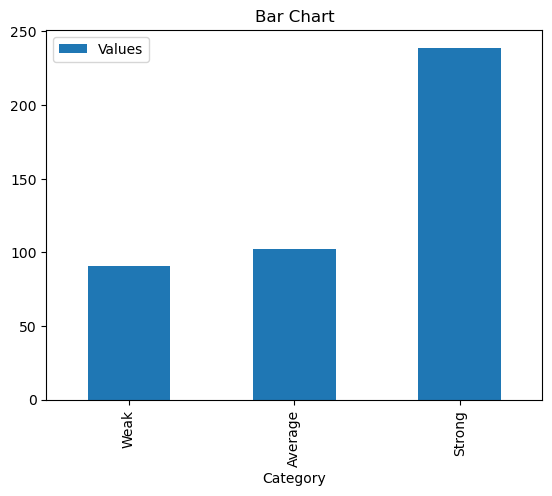

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
query = """
     SELECT count(*) [Weak] FROM cityofchicago
     WHERE parent_environment_icon ='Weak'
     UNION 
      SELECT count(*) [Average] FROM cityofchicago
      WHERE parent_environment_icon ='Average'
      UNION
      SELECT count(*) [Strong] FROM cityofchicago
      WHERE parent_environment_icon ='Strong'
 """
cur.execute(query)
result = cur.fetchall()
data = {'Category': ['Weak','Average','Strong'], 'Values': [i[0] for i in result]}
df = pd.DataFrame(data)
df.plot(kind='bar', x='Category', y='Values', title='Bar Chart')
plt.show()


In [38]:
query = """
    SELECT latitude,longitude FROM cityofchicago
    WHERE name_of_school = 'Michael M Byrne Elementary School'
 """
cur.execute(query)
result = cur.fetchone()
for i in result:
    print(i)

41.79503029
-87.79150778


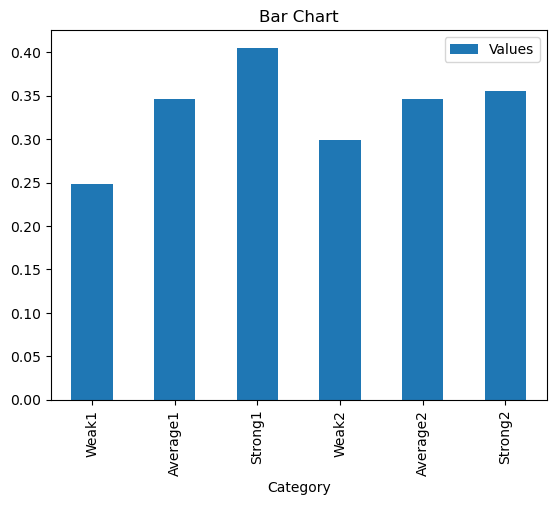

In [39]:
#-0.164446x+0.053071y + 11.5337805549716 =0
query = """
     SELECT count(*) [Weak1] FROM cityofchicago
     WHERE parent_environment_icon ='Weak' AND (-0.164446*latitude+0.053071*longitude + 11.5337805549716 > 0)
     UNION 
      SELECT count(*) [Average1] FROM cityofchicago
      WHERE parent_environment_icon ='Average' AND (-0.164446*latitude+0.053071*longitude + 11.5337805549716 > 0)
      UNION
      SELECT count(*) [Strong1] FROM cityofchicago
      WHERE parent_environment_icon ='Strong' AND -(0.164446*latitude+0.053071*longitude + 11.5337805549716 > 0)
      UNION 
      SELECT count(*) [Weak2] FROM cityofchicago
     WHERE parent_environment_icon ='Weak' AND (-0.164446*latitude+0.053071*longitude + 11.5337805549716 < 0)
     UNION 
      SELECT count(*) [Average2] FROM cityofchicago
      WHERE parent_environment_icon ='Average' AND (-0.164446*latitude+0.053071*longitude + 11.5337805549716 < 0)
      UNION
      SELECT count(*) [Strong2] FROM cityofchicago
      WHERE parent_environment_icon ='Strong' AND (-0.164446*latitude+0.053071*longitude + 11.5337805549716 < 0)
 """
cur.execute(query)
result = cur.fetchall()
tong1 = [result[0][0]+result[1][0]+result[2][0],result[3][0]+result[4][0]+result[5][0]]
data = {'Category': ['Weak1','Average1','Strong1','Weak2','Average2','Strong2'], 'Values': [i[0]/tong1[a//3] for a,i in enumerate(result)]}
df = pd.DataFrame(data)
df.plot(kind='bar', x='Category', y='Values', title='Bar Chart')
plt.show()

Mean Squared Error: 158.49932893375367
R^2 Score: 0.4792529685582819
0.015955541932076687 x + -7.923510791575289 = y


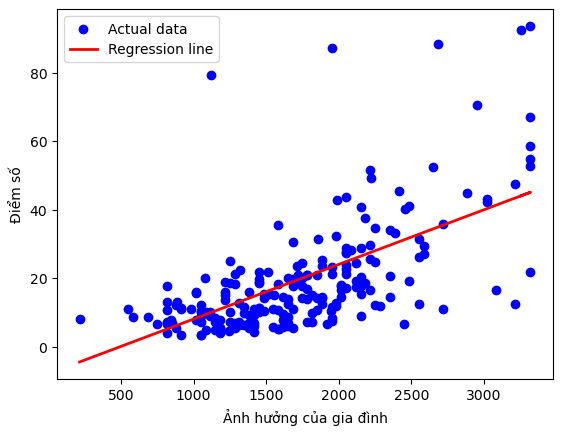

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
query = """
SELECT family_involvement_score [fs],parent_engagement_score,parent_environment_score,ISAT_Exceeding_Reading_ [ir],ISAT_Exceeding_Math_[im] FROM cityofchicago 
WHERE fs IS NOT NULL AND fs <> 'NDA' AND parent_engagement_score <> 'NDA'AND parent_environment_score<>'NDA' AND ir IS NOT NULL and im IS NOT NULL
ORDER BY fs
"""
cur.execute(query)
result = cur.fetchall()
result.sort(key=lambda x:int(x[0])+int(x[1])+int(x[2]))
x = np.array([int(i[0]+i[1]+i[2])/300 for i in result]).reshape(-1,1)
y = np.array([(i[3]+i[4])/2 for i in result])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
a = model.coef_[0]
b = model.intercept_
print(a,'x +',b ,'= y')
plt.scatter(x, y, color='blue', label='Actual data')
plt.plot(x, model.predict(x), color='red', linewidth=2, label='Regression line')
plt.xlabel('Ảnh hưởng của gia đình')
plt.ylabel('Điểm số')
plt.legend()
plt.show()

In [1]:
import pandas as pd 
import sqlite3
conn = sqlite3.connect('nam.db')
df = pd.read_sql_query( """
SELECT family_involvement_score [fs],parent_engagement_score,parent_environment_score,ISAT_Exceeding_Reading_ [ir],ISAT_Exceeding_Math_ [im],([ISAT_Exceeding_Reading_]+[ISAT_Value_Add_Math])/2 [I] FROM cityofchicago WHERE fs IS NOT NULL AND fs <> 'NDA' AND parent_engagement_score <> 'NDA'AND parent_environment_score<>'NDA' AND ir IS NOT NULL and im IS NOT NULL AND I IS NOT NULL ORDER BY fs """, con= conn)
df1 = df['I'].values

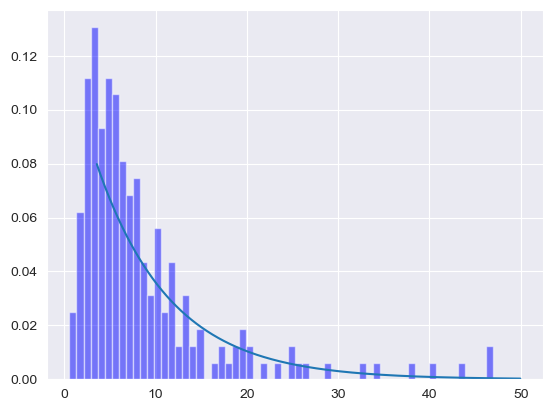

In [13]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df1, bins=60, color='blue', label='Actual data', alpha=0.5,density=True)
x = np.linspace(df1.min()+3, df1.max()+3,1000)
y = 1/np.sqrt(df1.var()) * np.exp(-1/np.sqrt(df1.var())* x)
plt.plot(x,y)
plt.show()

C:\Users\anhna\AppData\Local\Temp\ipykernel_16284\4032295844.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df1,
C:\Users\anhna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


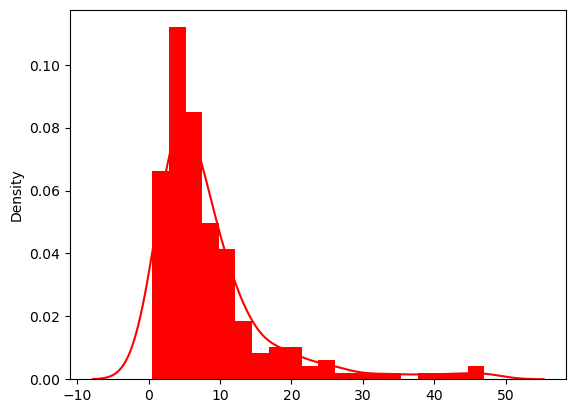

In [43]:
import seaborn  as sns
ax = sns.distplot(df1,
                  bins=20,
                  kde=True,
                  color='red',
                  hist_kws={"linewidth": 15,'alpha':1})

**Conclusion:** Since the p-value is less than 0.05, we will reject the null hypothesis as there is significant evidence that at least one of the means differ.